[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1VmMI2xL16e1I0ha9KMMWeaciW5jJXmK1?usp=sharing)

# Heat Sink 
As modern electronics often generate a significant amount of waste heat that could potentially destroy the device itself, building a [heat sink](https://en.wikipedia.org/wiki/Heat_sink) on top of the hot surface is a common approach to increase the rate of heat dissipation. A heat sink is generally a thin metal plate with many fins attached, increasing the surface area of the heat sink. Such that, more heat can be dissipated to the environment through the increased surface area. 

In this notebook, we will conduct a series of simulation with the Onshape model of a heat sink design to understand the properties of fins and heat sinks. The Onshape document of the model can be found in [this link](https://cad.onshape.com/documents/90a4d9714ef6b02d6588ec72/w/d59102477548ee2c306f9746/e/ef65b54bd20ceea1d75b8d86); please also feel free to make a copy and play around with the design. 

# Geometry of the Heat Sink

Dimensions: width x length x height: 
- Base: 0.1 x 0.1 x 0.001 m
- Fins: 0.001 x `Fin_Width` x 0.03 m 
- Fins spacing: `Fin_Spacing`

Allowed range of variables: 
- 0.001 m < `Fin_Width` < 0.1 m
- `Fin_Width` < `Fin_Spacing` < 0.1 m

In [ ]:
#@title Import and Setup Onshape Client

!pip install onshape-client
from onshape_client.client import Client
from onshape_client.onshape_url import OnshapeElement
import json

#@markdown Chage the base if using an enterprise (i.e. "https://ptc.onshape.com")
base = 'https://cad.onshape.com' #@param {type:"string"}

#@markdown Would you like to import your API keys from a file, or copy and paste them directly?
keyImportOption = "Upload Keys from File" #@param ["Upload Keys from File", "Copy/Paste Keys"]

from IPython.display import clear_output 
clear_output()
print("Onshape Client successfully imported!")

if keyImportOption == "Upload Keys from File":
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        execfile(fn)

    client = Client(configuration={"base_url": base,
                                    "access_key": access,
                                    "secret_key": secret})
    clear_output()
    print('Onshape client configured - ready to go!')
else:
    access = input("Paste your Onshape Access Key: ")
    secret = input("Paste your Onshape Secret Key: ")
    client = Client(configuration={"base_url": base,
                                    "access_key": access,
                                    "secret_key": secret})
    clear_output()
    print('Onshape client configured - ready to go!')


Onshape client configured - ready to go!


In [ ]:
#@title Onshape document location 
#@markdown Copy and paste the link to the Onshape document of the heat sink (must be in part studio): 
url = "https://cad.onshape.com/documents/90a4d9714ef6b02d6588ec72/w/d59102477548ee2c306f9746/e/ef65b54bd20ceea1d75b8d86" #@param{type:"string"}

fixed_url = '/api/partstudios/d/did/w/wid/e/eid'
element = OnshapeElement(url)
fixed_url = fixed_url.replace('did', element.did)
fixed_url = fixed_url.replace('wid', element.wvmid)
fixed_url = fixed_url.replace('eid', element.eid)

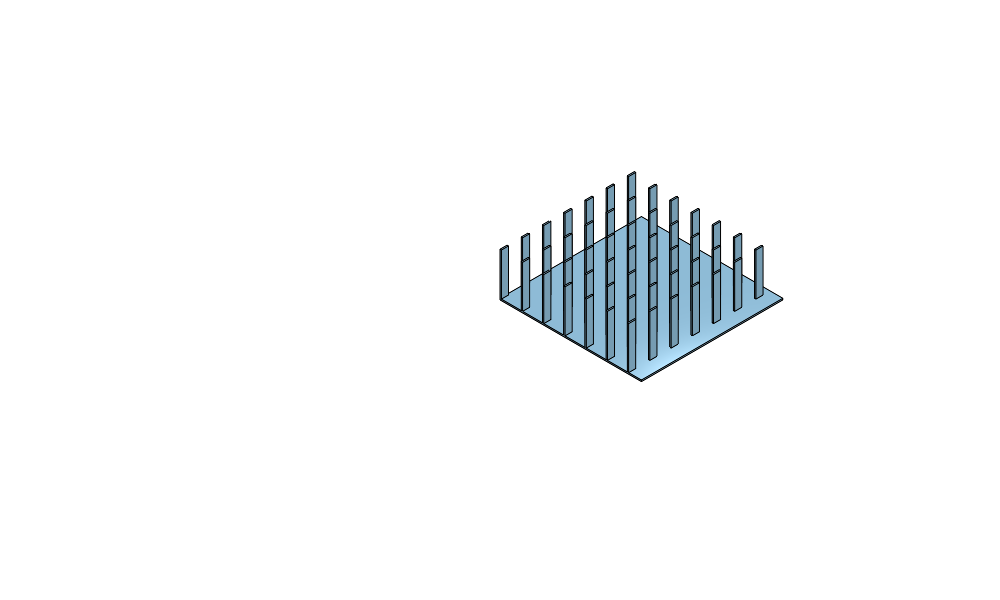

In [ ]:
from onshape_client.oas import configuration
#@title Define and view your heat sink 
#@markdown Define the dimension and the spacing of fins, both in meter: 
Fin_Width = 0.005 #@param{type:"number"}
Fin_Spacing = 0.015 #@param{type:"number"}

configDef = "Fin_Width%3D{}%2Bmeter%3BFin_Spacing%3D{}%2Bmeter".format(str(Fin_Width), str(Fin_Spacing))

#@markdown viewMatrix can be any face direction or isometric as a string, or a 1x12 view matrix
viewMatrix = "isometric" #@param {type:"string"}
#@markdown pixelSize is the size in meters for each pixel. If 0, it will fill the image size output
pixelSize = 0.0005 #@param {type:"number"}
showImage = True #@param {type:"boolean"}

from IPython.display import Image
import base64

def partStudioShadedView(viewMatrix = "isometric",pixelSize = 0.003):
    # Returns the base64 image string of a shaded view of a part studio
    # viewMatrix can be any face direction or isometric as a string, or a 1x12 view matrix
    method = 'GET'

    if any(face in viewMatrix for face in ["front","back","top","bottom","left","right"]):
        matrix = viewMatrix
    elif viewMatrix == "isometric":
        matrix = "0.612,0.612,0,0,-0.354,0.354,0.707,0,0.707,-0.707,0.707,0"
    elif isinstance(viewMatrix,list):
        matrix = str(viewMatrix).replace('[','').replace(']','')
    else: 
        matrix = None 

    ## View Matrix below is roughly isometric
    params = {'viewMatrix':matrix,
                'edges':'show',
                'outputHeight':600,
                'outputWidth':1000,
                'pixelSize':pixelSize, 
                'configuration': configDef}
    
    payload = {}
    headers = {'Accept': 'application/vnd.onshape.v1+json',
                'Content-Type': 'application/json'}

    response = client.api_client.request(method, url=base + fixed_url + "/shadedviews", query_params=params, headers=headers, body=payload)
    
    parsed = json.loads(response.data)
    imgdata = base64.b64decode(parsed['images'][0])
    with open("image.jpg", 'wb') as f:
        f.write(imgdata)
    
    return imgdata

if 0.001 < Fin_Width < 0.1 and Fin_Width < Fin_Spacing < 0.1: 
  img = partStudioShadedView(viewMatrix,pixelSize)
  if showImage:
    display(Image(img))
  else:
    pass
else: 
  print("ERROR: Please check the constraints on defined dimensions!")

# Heat Transfer Calculation 

Assume the ambient temperature, $T_\infty$, to be $25°\text{C}$, and assume the convection heat transfer coefficient, $h$, to be $20\frac{W}{m^2k}$. The heat sink is made out of stainless steel with a thermal conductivity: $k=15 \frac{W}{mK}$. 

Let's say that the heat sink is placed on top of a surface with $T_b = 50°\text{C}$. We are interested in calculating the total heat transfer, $\dot{Q}$, from the heat sink. 

$$
\begin{aligned} 
\dot{Q}_{total} &= \dot{Q}_{unfin} + \dot{Q}_{fin} \\
&= hA_{unfin}(T_b - T_\infty) + \eta_{fin} hA_{fin} (T_b - T_\infty) \\
&= h(A_{unfin} + \eta_{fin}A_{fin})(T_b - T_\infty) 
\end{aligned}
$$

where $\eta_{fin}$ is the heat transfer efficiency of one fin, $A_{fin}$ is the surface area of the fins, and $A_{unfin}$ is the surface area of the base plate. For the fins in this demo, their efficiencies can be calculated with: 
$$
\begin{aligned} 
m &\equiv \sqrt{\frac{hp}{kA_c}}\\
L_c &\equiv L + \frac{A_c}{p} \\
\Rightarrow \eta_{fin} &= \frac{\tanh{(mL_c)}}{mL_c}
\end{aligned}
$$
where $L$, $p$, and $A_c$ are the length, perimeter and cross-sectional area of a fin, respectively. With material properties and geometries of the fins given in this demo, the efficiency of the fins can be calculated with the function shown in the cell below. 

Hence, 
$$
\begin{aligned} 
\dot{Q}_{total} &= \biggl(20\frac{W}{m^2k}\biggr)(A_{unfin} + \eta_{fin} A_{fin})(50° C - 25° C) \\
\dot{Q}_{total} &= 500 A_{unfin} + 500 \eta_{fin} A_{fin} 
\end{aligned}
$$
The values of $A_{fin}$ and $A_{unfin}$ will be substituted in with the areas automatically calculated by the Onshape model. 

In [ ]:
#@title Run this cell to define function `calc_efficiency(Fin_Width)` and calculate the fins' efficiency
Fin_Width = 0.015 #@param{type: "number"}

import numpy as np 

def calc_efficiency(FW): 
    m = np.sqrt(8000/3 * (0.001+FW)/FW)
    Lc = 0.03 + FW/2000 / (0.001+FW)
    eff = np.tanh(m * Lc) / (m * Lc)
    return eff

efficiency = calc_efficiency(Fin_Width)
print("Fin Efficiency:", efficiency)


Fin Efficiency: 0.5694438309610714


# Experiment

To visualize the change in heat transfer with different heat sinks, we will: 
1. Vary the width of the fins (`Fin_Width`) 
2. Vary the spacing between fins (`Fin_Spacing`)
3. Find an optimal heat sink design by varying both the width and the spacing between fins 

In [ ]:
#@title Run this cell to define function `getVariableValue(url, config, varName)` to get variable values from Part Studio

# USING (MODIFIED) CODE FROM https://github.com/onshape-public/onshape-clients/blob/master/python/test/test_get_variables.py

import json
from onshape_client.oas import BTFeatureScriptEvalCall2377
from onshape_client.onshape_url import OnshapeElement
from onshape_client.utility import parse_quantity

script = r'''
    function(context, queries) {
            return getAllVariables(context);
        }
    '''
def getVariables(url, config):
    element = OnshapeElement(url)
    script_call = BTFeatureScriptEvalCall2377(script=script)
    response = client.part_studios_api.eval_feature_script(
        element.did,
        element.wvm,
        element.wvmid,
        element.eid,
        bt_feature_script_eval_call_2377=script_call,
        _preload_content=False,
        configuration=config
    )
    measurements = json.loads(response.data.decode("utf-8"))["result"]["message"]["value"]
    parsed_measurements = parse_variables_from_map(measurements)  
    vars = []
    for name, val in parsed_measurements.items():
        vars.append({name:val})
    return vars

def parse_variables_from_map(unparsed):
    parsed_variables = {}
    value = None
    for to_parse in unparsed:
        if is_fs_type(to_parse, "BTFSValueMapEntry"):
            key = to_parse["message"]["key"]["message"]["value"]
            candidate_message = to_parse["message"]["value"]
            if is_fs_type(candidate_message, ["BTFSValueMap", "BTFSValueArray"]):
                value = parse_variables_from_map(candidate_message["message"]["value"])
            elif is_fs_type(candidate_message, "BTFSValueWithUnits"):
                value = parse_quantity(candidate_message["message"])
            parsed_variables[key] = value
    return parsed_variables

def is_fs_type(candidate, type_name):
    result = False
    try:
        if isinstance(type_name, str):
            result = type_name == candidate["typeName"]
        elif isinstance(type_name, list):
            result = any(
                [type_name_one == candidate["typeName"] for type_name_one in type_name]
            )
    except Exception:
        result = False
    return result

def getVariableValue(url,config,varName):
    vars = getVariables(url,config)
    for x in vars:
        if varName in x:
            return(x[varName])

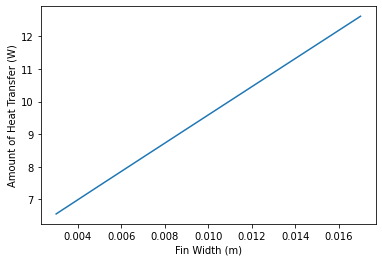

In [25]:
#@title Vary the width of the fins
#@markdown Define the range of variation of the fins' width
Fin_Width_min = 0.003 #@param{type:"number"}
Fin_Width_max = 0.015 #@param{type:"number"}
step_size = 0.002 #@param{type:"number"}
#@markdown Define a common fin spacing for all heat sinks 
Fin_Spacing = 0.02 #@param{type:"number"}

import numpy as np 
import matplotlib.pyplot as plt

configDef = "Fin_Width%3D{}%2Bmeter%3BFin_Spacing%3D{}%2Bmeter"

def vary_FW(FW_min, FW_max, step_size, FS): 
    heat_transfer = []
    FWs = np.arange(FW_min, FW_max + step_size, step_size)
    for fw in FWs: 
        config = configDef.format(str(fw), str(FS))
        method = "GET"
        params = {'partId': "JHD", 
                "configuration": config}
        payload = {}
        headers = {'Accept': 'application/vnd.onshape.v2+json; charset=UTF-8;qs=0.1',
                'Content-Type': 'application/json'}
        response = client.api_client.request(method, url=base + fixed_url + '/massproperties', query_params=params, headers=headers, body=payload)
        parsed = json.loads(response.data)
        
        # Calculate heat transfer 
        surface_area = np.mean(parsed["bodies"]["-all-"]["periphery"]) 
        area_unfin = float(getVariableValue(url, config, "Area_Unfin").split("*")[0])
        area_fin = surface_area - area_unfin - 0.0104
        heat_transfer.append(500 * (area_unfin + calc_efficiency(fw) * area_fin))

    plt.plot(FWs, heat_transfer)
    plt.xlabel("Fin Width (m)")
    plt.ylabel("Amount of Heat Transfer (W)")
    plt.show()

if 0.1 > Fin_Width_max > Fin_Width_min > 0.001 and Fin_Width_max < Fin_Spacing < 0.1:
    vary_FW(Fin_Width_min, Fin_Width_max, step_size, Fin_Spacing)
else: 
    print("ERROR: Please check the constraints on defined dimensions!")

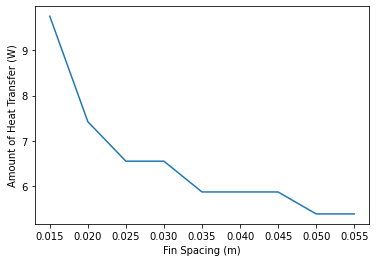

In [26]:
from matplotlib.font_manager import findSystemFonts
from ruamel.yaml.tokens import FlowSequenceStartToken
#@title Vary the spacing of the fins 
#@markdown Define the range of variation of the fins' spacing
Fin_Spacing_min =  0.015#@param{type:"number"}
Fin_Spacing_max = 0.055 #@param{type:"number"}
step_size = 0.005 #@param{type:"number"}
#@markdown Define a common width for all fins 
Fin_Width =  0.005#@param{type:"number"}

import numpy as np 
import matplotlib.pyplot as plt

configDef = "Fin_Width%3D{}%2Bmeter%3BFin_Spacing%3D{}%2Bmeter"

def vary_fin_spacing(FS_min, FS_max, step_size, FW): 
    heat_transfer = []
    FSs = np.arange(FS_min, FS_max + step_size, step_size)
    for fs in FSs: 
        config = configDef.format(str(FW), str(fs))
        method = "GET"
        params = {'partId': "JHD", "configuration": config}
        payload = {}
        headers = {'Accept': 'application/vnd.onshape.v2+json; charset=UTF-8;qs=0.1',
                   'Content-Type': 'application/json'}
        response = client.api_client.request(method, url=base + fixed_url + '/massproperties', query_params=params, headers=headers, body=payload)
        parsed = json.loads(response.data)

        # Calculate heat transfer 
        surface_area = np.mean(parsed["bodies"]["-all-"]["periphery"]) 
        area_unfin = float(getVariableValue(url, config, "Area_Unfin").split("*")[0])
        area_fin = surface_area - area_unfin - 0.0104
        heat_transfer.append(500 * (area_unfin + calc_efficiency(FW) * area_fin))

    plt.plot(FSs, heat_transfer)
    plt.xlabel("Fin Spacing (m)")
    plt.ylabel("Amount of Heat Transfer (W)")
    plt.show()

if 0.1 > Fin_Width > 0.001 and Fin_Width < Fin_Spacing_min < Fin_Spacing_max < 0.1:
    vary_fin_spacing(Fin_Spacing_min, Fin_Spacing_max, step_size, Fin_Width)
else: 
    print("ERROR: Please check the constraints on defined dimensions!")

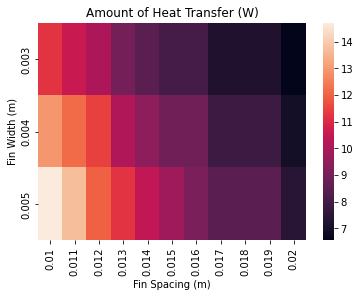

In [27]:
#@title Finding an optimal heat sink 
#@markdown Define the range of variation of the heat sink's base 
Fin_Width_min = 0.003 #@param{type: "number"}
Fin_Width_max =  0.005#@param{type: "number"}
Fin_Width_step = 0.001 #@param{type: "number"}
#@markdown Define the range of variation of the fins' spacing 
Fin_Spacing_min = 0.01 #@param{type: "number"}
Fin_Spacing_max = 0.02 #@param{type: "number"}
Fin_Spacing_step = 0.001 #@param{type: "number"}

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

configDef = "Fin_Width%3D{}%2Bmeter%3BFin_Spacing%3D{}%2Bmeter"

def optimal_heat_sink(FW_min, FW_max, FW_step, FS_min, FS_max, FS_step): 
    # Row: Base Dimension; Column: Fin Spacing 
    heat_transfer = [] 
    FWs = np.arange(FW_min, FW_max + FW_step, FW_step)
    FSs = np.arange(FS_min, FS_max + FS_step, FS_step)

    for fw in FWs: 
        heat_row = [] 
        for fs in FSs: 
            config = configDef.format(str(fw), str(fs))
            method = "GET"
            params = {'partId': "JHD", "configuration": config}
            payload = {}
            headers = {'Accept': 'application/vnd.onshape.v2+json; charset=UTF-8;qs=0.1', 
                    'Content-Type': 'application/json'}
            response = client.api_client.request(method, url=base + fixed_url + '/massproperties', query_params=params, headers=headers, body=payload)
            parsed = json.loads(response.data)

            # Calculate heat transfer
            surface_area = np.mean(parsed["bodies"]["-all-"]["periphery"]) 
            area_unfin = float(getVariableValue(url, config, "Area_Unfin").split("*")[0])
            area_fin = surface_area - area_unfin - 0.0104
            heat_row.append(500 * (area_unfin + calc_efficiency(fw) * area_fin))
        heat_transfer.append(heat_row)
        
    # Plotting heatmap 
    sns.heatmap(heat_transfer, 
                xticklabels=np.round(FSs, 3), 
                yticklabels=np.round(FWs, 3))
    plt.xlabel("Fin Spacing (m)")
    plt.ylabel("Fin Width (m)")
    plt.title("Amount of Heat Transfer (W)")
    plt.show()

if 0.1 > Fin_Width_max > Fin_Width_min > 0.001 and Fin_Width_max < Fin_Spacing_min < Fin_Spacing_max < 0.1: 
    optimal_heat_sink(Fin_Width_min, Fin_Width_max, Fin_Width_step, 
                      Fin_Spacing_min, Fin_Spacing_max, Fin_Spacing_step)
else: 
    print("ERROR: Please check the constraints on defined dimensions!")

As you may be able to tell from the plots above: 
- Increase the width of the fins ⇒ an increased amount of surface area for heat dissipation as we get wider fins ⇒ increasing amount of heat transfer from the heat sink. 
-  Increase the spacing of the fins ⇒ we can fit less fins on the heat sink due to increased spacing ⇒ a decreased amount of surface area for heat dissipation ⇒ decreasing amount of heat transfer from the heat sink. 

Therefore, to design an optimal heat sink for a heat dissipating surface, we should aim to fit as many fins as possible on the heat sink. Meanwhile, increasing the width of the fins also enlarge the heat dissipating area of the entire heat sink. 

# Limitations 

There are also limitations to certain assumptions and constraints used in this demo: 
1. The amount of heat conduction from the hot surface to the finned surface of the base plate is assumed to be negligible in this demo due to its relatively small thickness. 
2. When fins are placed too closed together, heat suffocation may occur, decreasing the $h$ value of the environment, hence less amount of heat transfer from the heat sink. 

# Challenge Questions 

1. Change the shape of the fins in the Onshape model, so that we can further demonstrate the advantages of using Onshape to automatically calculate the surface area instead of hand calculations. 
    - For the fins' efficiency, simply assume the fin to be a rectangular prism as they are. 
2. Add a third variable to the design of the heat sink (e.g., fin's height, fin's thickness, etc.), and study how this additional variable affects the amount of heat transfer from the heat sink. 
    - Note that you may also need to change the `calc_efficiency()` function for fin efficiency as you change the geometry of the fins. 